In [1]:
import torch 
import pandas as pd 
import torch.nn as nn 
from torch.utils.data import random_split, DataLoader, TensorDataset 
import torch.nn.functional as F 
import numpy as np 
import torch.optim as optim 
from torch.optim import AdamW
import random
import matplotlib.pyplot as plt
import seaborn as sns

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


In [2]:
df = pd.read_csv('Данные.csv', sep=';')

In [3]:
df.head()

,k,lu,P0,I,gamma,sgamma,r,Psat,Lsat,loptim,lres,loptim/lres,Psat/Pall,Lsat/lu,f,rho,P0/Pall
0,3.89,3.69,12800000.0,80.0,2650.0,0.0,0.0001,1.430000e+08,18.5,2.261250e-08,2.257770e-08,0.001542,0.00132,5.01,0.736,0.000965,1.180000e-04
1,3.89,3.69,12800.0,80.0,1000.0,0.0,0.0001,9.800000e+07,16.7,1.585280e-07,1.580440e-07,0.003065,0.00240,4.52,0.736,0.002550,3.130000e-07
2,3.98,3.69,150000.0,500.0,2830.0,0.0,0.0001,1.130000e+09,20.3,2.061380e-08,2.057220e-08,0.002024,0.00156,5.49,0.735,0.001690,2.070000e-07
3,3.98,3.69,1500000.0,500.0,3160.0,0.0,0.0001,1.100000e+09,18.3,1.648760e-08,1.645770e-08,0.001814,0.00136,4.96,0.735,0.001510,1.850000e-06
4,3.98,3.69,150000.0,500.0,2650.0,0.0,0.0001,1.180000e+09,19.4,2.356200e-08,2.351110e-08,0.002164,0.00175,5.25,0.735,0.001800,2.210000e-07


In [4]:
df = df.dropna()

In [5]:
l = len(df)

In [6]:
df = df[df['Psat/Pall']<0.008]

In [7]:
df['log'] = np.log(df[['Psat/Pall']])
df['log0'] = np.log(df['P0']/df['I']/df['gamma']/511000)
df['optim'] = df['loptim/lres']/df['Psat/Pall']
df['Lsat/lu'] = np.log(df['Lsat/lu'])
df['sqgamma'] = np.log(df['gamma'])

In [8]:
df = df[df['optim']<=2]

In [9]:
len(df)/l

0.9070138150903294

In [10]:
df['optim'] = df['loptim/lres']/df['rho']

In [11]:
df['optim'] = (df['optim'])

In [12]:
df1 = df.drop(columns=['gamma', 'P0', 'optim', 'P0/Pall', 'Psat', 'Lsat', 'loptim','lres', 'loptim/lres', 'Psat/Pall', 'Lsat/lu', 'f', 'rho', 'log'])

In [13]:
df1

,k,lu,I,sgamma,r,log0,sqgamma
0,3.89,3.69,80.0,0.00000,0.00010,-9.043511,7.882315
1,3.89,3.69,80.0,0.00000,0.00010,-14.976706,6.907755
2,3.98,3.69,500.0,0.00000,0.00010,-15.388374,7.948032
3,3.98,3.69,500.0,0.00000,0.00010,-13.196085,8.058327
4,3.98,3.69,500.0,0.00000,0.00010,-15.322657,7.882315
...,...,...,...,...,...,...,...
1877,1.72,1.99,7600.0,0.00005,0.00001,-16.247034,10.275051
1878,1.72,1.99,7600.0,0.00005,0.00001,-11.532665,10.165852
1879,3.29,1.99,4500.0,0.00005,0.00001,-11.512708,10.404263
1880,3.29,1.99,4500.0,0.00005,0.00001,-11.653787,10.545341


In [14]:
df2 = df.drop(columns=['sqgamma', 'k', 'lu', 'I', 'gamma', 'sgamma', 'r', 'log0', 'P0', 'P0/Pall', 'loptim','lres', 'loptim/lres', 'Psat/Pall', 'Lsat', 'f', 'rho', 'Psat'])

In [15]:
df2

,Lsat/lu,log,optim
0,1.611436,-6.630124,1.598041
1,1.508512,-6.032287,1.201894
2,1.702928,-6.463069,1.197420
3,1.601406,-6.600271,1.201364
4,1.658228,-6.348139,1.202222
...,...,...,...
1877,2.360854,-7.606921,0.798766
1878,1.829376,-7.086882,1.198454
1879,1.906575,-7.127156,1.200737
1880,2.034706,-7.268725,1.197812


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df1, df2, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)



In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

scaler2 = MinMaxScaler()
scaler2.fit(y_train)

y_train = scaler2.transform(y_train)
y_test = scaler2.transform(y_test)
y_val = scaler2.transform(y_val)


In [18]:

X_train = torch.Tensor(X_train) 
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

train_set = TensorDataset(X_train, y_train) 
validate_set = TensorDataset(X_val, y_val) 
test_set = TensorDataset(X_test, y_test) 


# Create Dataloader to read the data within batch sizes and put into memory. 
train_loader = DataLoader(train_set, batch_size = 64, shuffle = True) 
validate_loader = DataLoader(validate_set, batch_size = 20) 
test_loader = DataLoader(test_set, batch_size = 1)

In [19]:
train_dataset_array = next(iter(train_loader))[0].numpy()
train_dataset_array 

array([[0.03344481, 0.46488294, 0.07614213, 0.        , 0.11594203,
        0.38745704, 0.47627386],
       [0.2541806 , 0.6688963 , 0.5025381 , 0.        , 0.42028984,
        0.51257414, 0.6090432 ],
       [0.22408026, 0.50167227, 0.6040609 , 0.5       , 0.02898551,
        0.4730055 , 0.56033206],
       [0.4916388 , 0.34448162, 0.70558375, 0.        , 0.42028984,
        0.64954364, 0.6932179 ],
       [0.66220737, 0.89966553, 0.70558375, 0.        , 0.07246377,
        0.64118177, 0.6090432 ],
       [0.4347826 , 0.8561873 , 0.42131978, 0.2       , 0.04347826,
        0.15162516, 0.84266347],
       [0.04682274, 0.729097  , 0.6040609 , 0.1       , 0.71014494,
        0.37730882, 0.45869353],
       [0.22408026, 0.8929766 , 0.06598984, 0.5       , 0.05797102,
        0.650167  , 0.4479199 ],
       [0.36789298, 0.3043478 , 0.8071066 , 0.1       , 0.1594203 ,
        0.29905614, 0.7573984 ],
       [0.77591974, 0.0735786 , 0.70558375, 0.5       , 0.2753623 ,
        0.5440797 , 0.5

In [20]:
# Define model parameters 
input_size = list(X_train.shape)[1]   
output_size = list(y_train.shape)[1]  



# Define neural network 
class Network(nn.Module): 
    def __init__(self, input_size, output_size, init_form="normal"): 
        super().__init__() 
        self.conv_stack = nn.Sequential(
        nn.Linear(input_size, 100), 
        nn.Tanh(),
        nn.Dropout(p=0.1),
        nn.Linear(100, 100),
        nn.Tanh(),
        nn.Dropout(p=0.1),
        nn.Linear(100, 100),
        nn.Tanh(),
        nn.Dropout(p=0.1))
        
        self.conv_stack1 = nn.Sequential(
        nn.Linear(100, 100), 
        nn.Tanh(),
        nn.Dropout(p=0.1),
        nn.Linear(100, 30),
        nn.Tanh(), 
        nn.Dropout(p=0.1),
        nn.Linear(30, 1))
                
        self.conv_stack2 = nn.Sequential(
        nn.Linear(100, 100), 
        nn.Tanh(),
        nn.Dropout(p=0.1),
        nn.Linear(100, 30),
        nn.Tanh(), 
        nn.Dropout(p=0.1),
        nn.Linear(30, 1))
        
        self.conv_stack3 = nn.Sequential(
        nn.Linear(100, 100), 
        nn.Tanh(),
        nn.Dropout(p=0.1),
        nn.Linear(100, 30),
        nn.Tanh(), 
        nn.Dropout(p=0.1),
        nn.Linear(30, 1))
            
        
        self.init_form = init_form
        if self.init_form is not None:
            self.init()

    def forward(self, x): 
        s = self.conv_stack(x)
        out1 = self.conv_stack1(s)
        out2 = self.conv_stack2(s)
        out3 = self.conv_stack3(s)
        return out1, out2, out3
    
    
        # xavier weight initialization
    def init(self):
        sigmoid_gain = torch.nn.init.calculate_gain("tanh")
        for child in self.conv_stack.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.xavier_normal_(child.weight,
                                                 gain=sigmoid_gain)
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.xavier_uniform_(child.weight,
                                                  gain=sigmoid_gain)
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_epoch(model,
                optimizer,
                criterion,
                train_loader):
    loss_history = []
    for batch in train_loader: 
        optimizer.zero_grad()
        x_train, y_train = batch # parse data
        x_train, y_train = x_train.to(device), y_train.to(device) # compute on gpu
        y1, y2, y3 = model(x_train) # get predictions
        loss = criterion(y1, y_train[:, 0:1]) + criterion(y2, y_train[:,1:2]) + criterion(y3, y_train[:,2:]) # compute loss
        loss_history.append(loss.cpu().detach().numpy()) # write loss to log
        loss.backward()
        optimizer.step()
    return loss_history

In [22]:
def validate(model,
             criterion,
             val_loader):
    cumloss = 0
    loss_history = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train = batch # parse data
            x_train, y_train = x_train.to(device), y_train.to(device) # compute on gpu
            y1, y2, y3 = model(x_train) # get predictions
            loss = criterion(y1, y_train[:, 0:1]) + criterion(y2, y_train[:,1:2]) + criterion(y3, y_train[:,2:]) # compute loss
            loss_history.append(loss.cpu().detach().numpy()) # write loss to log
            cumloss += loss
    return cumloss / len(val_loader), loss_history # mean loss and history

In [23]:
from tqdm import tqdm

def train_model(model, optimizer, model_name=None, n_epochs=5):
  
    criterion = nn.MSELoss().to(device)

    train_history = {}
    train_history['model_name'] = model_name
    train_history['loss_on_train'] = []
    train_history['loss_on_test'] = []

    for epoch in tqdm(range(n_epochs)):
        loss_on_train = train_epoch(model,
                                    optimizer,
                                    criterion,
                                    train_loader)
        _, loss_on_test = validate(model,
                                   criterion,
                                   validate_loader)
        train_history['loss_on_train'].append(np.mean(loss_on_train))
        train_history['loss_on_test'].append(np.mean(loss_on_test))
        scheduler.step()
    return train_history

In [24]:
def exponential_smoothing(scalars, weight):  
    last = scalars[0]  
    smoothed = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  
        smoothed.append(smoothed_val)                        
        last = smoothed_val                                 

    return smoothed


def plot_history(history, n_epochs=5, smooth_val=0.9):
    fig, ax =  plt.subplots(3, 1, figsize=(12, 14))
    for stage_idx, (stage_lbl, stage_title) in enumerate(
        zip(['loss_on_train', 'loss_on_test'],
            ['train loss', 'test loss'])):
        # plot history on each learning step
        epoch_len = len(history[stage_lbl])//n_epochs
        full_stage_len = len(history[stage_lbl])
        ax[stage_idx].plot(exponential_smoothing(history[stage_lbl], smooth_val),
                           label='smoothed',
                           color='m')
        ax[stage_idx].plot(history[stage_lbl],
                           label='raw',
                           alpha=0.2,
                           color='c')
        ax[stage_idx].set_title(stage_title)
        ax[stage_idx].set_xlabel('epochs')
        ax[stage_idx].set_ylabel('loss')
        epochs_ticks_positions = np.arange(stop=full_stage_len+1,
                                           step=epoch_len)
        ax[stage_idx].set_xticks(np.arange(0,1000,100))
        ax[stage_idx].set_xticklabels(np.arange(0,1000,100))
        ax[stage_idx].legend()

        # plot mean train and test loss combined
        mean_loss_on_epoch = [np.mean(history[stage_lbl][i:i+epoch_len]) \
                              for i in range(0, full_stage_len, epoch_len)]
        std_loss_on_epoch = [np.std(history[stage_lbl][i:i+epoch_len]) \
                              for i in range(0, full_stage_len, epoch_len)]

        ax[2].set_title('\nAverage loss per epoch')
        ax[2].errorbar(np.arange(n_epochs) + stage_idx / 30.,
                       mean_loss_on_epoch,
                       yerr=std_loss_on_epoch,
                       capsize=5,
                       fmt="X--",
                       label=stage_title)
        ax[2].set_xticks(np.arange(0,1000,100))
        ax[2].set_xticklabels(np.arange(0,1000,100))
        ax[2].set_xlabel('epochs')
        ax[2].set_ylabel('loss')
        ax[2].legend()

    fig.suptitle(history['model_name'], fontsize=24)
    plt.show()

In [25]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


set_random_seed(42)

model = Network(input_size,output_size).to(device) 
optimizer = optim.AdamW(model.parameters(), lr=0.001)

lambda1 = lambda epoch: 0.998 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1, last_epoch = -1)

n_epochs = 1000
history = train_model(model, optimizer, model_name='model', n_epochs=n_epochs)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:37<00:00, 10.27it/s]


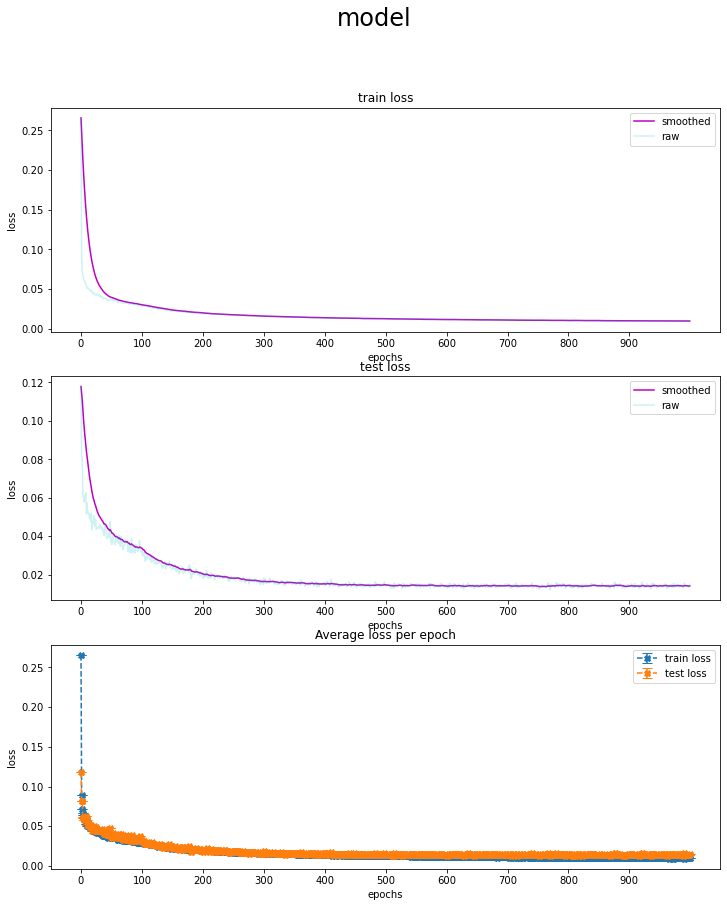

In [26]:
plot_history(history, n_epochs=n_epochs)


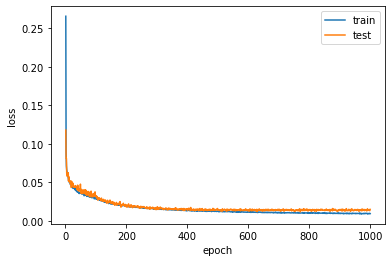

In [27]:
plt.plot(range(1,n_epochs+1), (history['loss_on_train']), label='train')
plt.plot(range(1,n_epochs+1), (history['loss_on_test']), label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [28]:
model.eval()

Network(
  (conv_stack): Sequential(
    (0): Linear(in_features=7, out_features=100, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.1, inplace=False)
  )
  (conv_stack1): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=100, out_features=30, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=30, out_features=1, bias=True)
  )
  (conv_stack2): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=100, out_features=30, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_feat

In [29]:
def relative_abs_error(true, pred):
    num = np.sum(np.abs(true - pred))
    den = np.sum(np.abs(true))
    squared_error = num/den
    rrmse_loss = (squared_error)
    return rrmse_loss


def test(model, val_loader):
    cumloss1 = 0
    cumloss2 = 0
    cumloss3 = 0
    l1 = []
    l2 = []
    l3 = []
    l4 = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train = batch # parse data
            x_train, y_train = x_train.to(device), y_train.to(device) # compute on gpu
            y_pred = torch.cat(model(x_train),1) # get predictions
            y_pred = scaler2.inverse_transform(y_pred.cpu().detach().numpy())
            y_train = scaler2.inverse_transform(y_train.cpu().detach().numpy())
            loss1 = relative_abs_error(np.exp(y_pred[0][0]), 
                                                    np.exp(y_train[0][0])) # compute loss
            loss2 = relative_abs_error(np.exp(y_pred[0][1]), 
                                                    np.exp(y_train[0][1]))
            loss3 = relative_abs_error((y_pred[0][2]), 
                                                    (y_train[0][2]))
            cumloss1 += loss1
            cumloss2 += loss2
            cumloss3 += loss3
            l1.append(loss1)
            l2.append(loss2)
            l3.append(loss3)
            l4.append(x_train.cpu().detach().numpy())
    return cumloss1 / len(val_loader), cumloss2 / len(val_loader), cumloss3 / len(val_loader), l1, l2, l3, l4


l = test(model, test_loader)
print('acc for Lsat=', l[0],'\n' 'acc for Psat=', l[1], '\n' 'acc for optim=', l[2])

acc for Lsat= 0.055333974958419234 
acc for Psat= 0.09806225094175795 
acc for optim= 0.151078057970451


Text(0.5, 1.0, 'Lsat error')

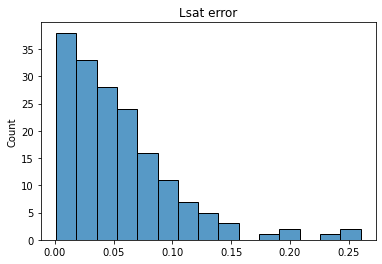

In [30]:
sns.histplot(l[3])
plt.title("Lsat error")

Text(0.5, 1.0, 'Power error')

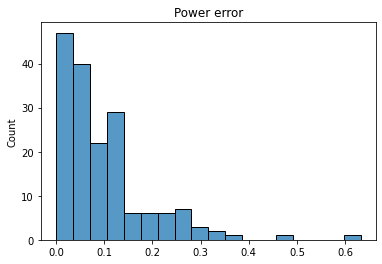

In [31]:
sns.histplot(l[4])
plt.title("Power error")

In [32]:
pd.Series(l[4]).sort_values().tail(20)
#scaler.inverse_transform(np.array([X_test[103].cpu().detach().numpy()]))

143    0.220020
43     0.225928
46     0.227741
22     0.237590
35     0.242115
11     0.254136
146    0.255378
135    0.256404
111    0.261256
33     0.269618
86     0.272049
129    0.277935
34     0.285919
102    0.288295
78     0.298147
64     0.328062
159    0.332591
47     0.380434
169    0.473399
96     0.632012
dtype: float32

In [33]:
scaler.inverse_transform(l[6][18])

array([[ 3.43000007e+00,  2.86000013e+00,  7.00000000e+03,
         1.00000005e-04,  9.00000014e-05, -1.02147408e+01,
         8.05832767e+00]], dtype=float32)

Text(0.5, 1.0, 'optim error')

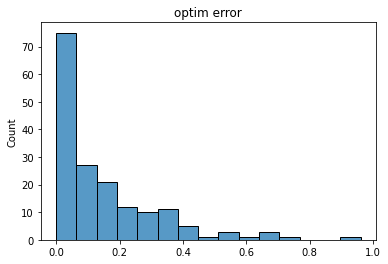

In [34]:
sns.histplot(l[5])
plt.title("optim error")

In [35]:
from scipy.special import jv

X = pd.DataFrame({'k':[2.13], 'lu':[2.8], 'I':[53],  'sgamma':[0.0002], 
                  'r':[0.00012], 'log0':[10], 'sqgamma': [np.log(300)]})

ksi = X['k']**2/(1+X['k']**2/2)/4
f = jv(0,ksi)-jv(1,ksi)
rho = 1/2/(np.exp(X['sqgamma']))*(X['I']/X['r']**2/np.pi/4/np.pi/17000*(X['lu']/100*X['k']*f)**2)**(1/3)


X['log0'] = np.log(X['log0']/X['I']/np.exp(X['sqgamma'])/511000)


X = scaler.transform(X)

In [36]:
input1 = torch.Tensor(X) 

In [37]:
a = (torch.cat(model(input1.to(device)),1)).cpu().detach().numpy()
a= scaler2.inverse_transform(a)
a

array([[ 1.6327567, -6.043516 ,  1.0047495]], dtype=float32)

In [38]:

X = pd.DataFrame({'k':[2.13], 'lu':[2.8], 'I':[53],  'sgamma':[0.0002], 
                  'r':[0.00012], 'log0':[10], 'sqgamma': [np.log(300)]})

P_0 = X['log0']

ksi = X['k']**2/(1+X['k']**2/2)/4
f = jv(0,ksi)-jv(1,ksi)

rho = 1/2/(np.exp(X['sqgamma']))*(X['I']/X['r']**2/np.pi/4/np.pi/17000*(X['lu']/100*X['k']*f)**2)**(1/3)
X['log0'] = np.log(X['log0']/X['I']/np.exp(X['sqgamma'])/511000)


L_sat = np.exp(a[0][0])*X['lu'][0]
P_sat = (np.exp(a[0][1])*np.exp(X['sqgamma'])*511000*X['I'])[0]

print('Lsat=', np.exp(a[0][0])*X['lu'][0], 'Psat=', (np.exp(a[0][1])*np.exp(X['sqgamma'])*511000*X['I'])[0], 
'loptim=',(((a[0][2])*rho+1)*X['lu']/100/2/np.exp(X['sqgamma'])/np.exp(X['sqgamma'])*(1+X['k']*X['k']/2))[0])

Lsat= 14.330298614501952 Psat= 19282011.948153373 loptim= 5.103993424225048e-07


In [39]:
len(df)

1707

0    2.047438e+07
Name: log0, dtype: float64


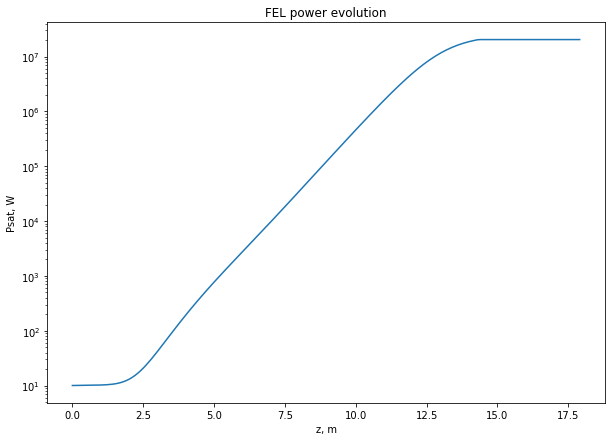

In [64]:
def P(z,P_0,P_sat,L_sat):
    def A(z,L):
        return 1/9*(3+2*np.cosh(z/L)+4*np.cos(3**(0.5)/2*z/L)*np.cosh(z/(2*L)))
    L = L_sat/1.1/np.log(9*P_sat/P_0)
    if z<L_sat:
        return P_0*(A(z,L)*np.exp(0.233*z/L_sat))/(1+P_0/P_sat*(A(z,L)-1))
    else: 
        return P_0*(A(L_sat,L)*np.exp(0.233*L_sat/L_sat))/(1+P_0/P_sat*(A(L_sat,L)-1))

print(P(L_sat,P_0,P_sat,L_sat))

 
# exponential function y = 10^x
data = [P(i,P_0,P_sat,L_sat) for i in np.arange(0, int(1.3*L_sat), 0.1)]


plt.figure(figsize=(10, 7))
# convert y-axis to Logarithmic scale
plt.yscale("log")
plt.xlabel('z, m')
plt.ylabel('Psat, W')
plt.title('FEL power evolution')

 
plt.plot(np.arange(0, int(1.3*L_sat), 0.1), data)

In [459]:
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, SubsetRandomSampler, ConcatDataset


In [460]:
criterion = nn.MSELoss()
set_random_seed(42)

num_epochs=1000
batch_size=64
k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

In [461]:
history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc1':[], 'test_acc2':[], 
          'test_acc3':[]}

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(df1)))):

    print('Fold {}'.format(fold + 1))
    
    X_train = df1.iloc[train_idx]
    X_test = df1.iloc[val_idx]
    y_train = df2.iloc[train_idx]
    y_test = df2.iloc[val_idx]
    
    scaler = MinMaxScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)


    scaler2 = MinMaxScaler()
    scaler2.fit(y_train)

    y_train = scaler2.transform(y_train)
    y_test = scaler2.transform(y_test)
    
    
    X_train = torch.Tensor(X_train) 
    y_train = torch.Tensor(y_train)

    X_test = torch.Tensor(X_test)
    y_test = torch.Tensor(y_test)

    train_set = TensorDataset(X_train, y_train) 
    test_set = TensorDataset(X_test, y_test) 


    # Create Dataloader to read the data within batch sizes and put into memory. 
    train_loader = DataLoader(train_set, batch_size = 64, shuffle = True) 
    test_loader = DataLoader(test_set, batch_size = 20)

    
    model = Network(input_size,output_size).to(device) 
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    
    lambda1 = lambda epoch: 0.998 ** epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1, last_epoch = -1)


    for epoch in range(num_epochs):
        loss_on_train = train_epoch(model, optimizer, criterion, train_loader)
        train_loss = float(np.mean(loss_on_train))
        _, loss_on_test = validate(model, criterion, test_loader)
        test_loss = float(np.mean(loss_on_test))
        train_acc = test(model, train_loader)
        test_acc = test(model, test_loader)
        scheduler.step()
        
        print("Epoch:{}/{}".format(epoch + 1, num_epochs))
        print('Loss on train=', train_loss)
        print('Loss on test=', test_loss)
        print('acc for Lsat=', test_acc[0],'\n' 'acc for Psat=', test_acc[1], '\n' 'acc for optim=', test_acc[2])
        
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    #history['train_acc'].append(train_acc)
    history['test_acc1'].append(test_acc[0])  
    history['test_acc2'].append(test_acc[1])  
    history['test_acc3'].append(test_acc[2])  

Fold 1
Epoch:1/1000
Loss on train= 0.08542811870574951
Loss on test= 0.036827389150857925
acc for Lsat= 0.6435098354187276 
acc for Psat= 0.6896814983338118 
acc for optim= 0.19622140445022118
Epoch:2/1000
Loss on train= 0.02992241270840168
Loss on test= 0.02722686529159546
acc for Lsat= 0.3688102663598127 
acc for Psat= 0.5031620230939653 
acc for optim= 0.15890241243566075
Epoch:3/1000
Loss on train= 0.0239699799567461
Loss on test= 0.027174176648259163
acc for Lsat= 0.5277412767625518 
acc for Psat= 0.43931180104199385 
acc for optim= 0.2555303463919295
Epoch:4/1000
Loss on train= 0.021186212077736855
Loss on test= 0.021732905879616737
acc for Lsat= 0.4702269856093658 
acc for Psat= 0.4093520034932428 
acc for optim= 0.2641823978887664
Epoch:5/1000
Loss on train= 0.02076485939323902
Loss on test= 0.022011402994394302
acc for Lsat= 0.5610672754442526 
acc for Psat= 0.44310582677523297 
acc for optim= 0.19653205630472964
Epoch:6/1000
Loss on train= 0.020430821925401688
Loss on test= 0

In [462]:
avg_train_loss = np.mean(history['train_loss'])
avg_test_loss = np.mean(history['test_loss'])
avg_test_acc1 = np.mean(history['test_acc1'])
avg_test_acc2 = np.mean(history['test_acc2'])
avg_test_acc3 = np.mean(history['test_acc3'])

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.4f} \t Average Test Loss: {:.4f} \t Average Lsat Acc: {:.3f} \t Average Psat Acc: {:.3f} \t Average Loptim Acc: {:.3f}".format(avg_train_loss,avg_test_loss,avg_test_acc1,avg_test_acc2,
avg_test_acc3))  

Performance of 5 fold cross validation
Average Training Loss: 0.0033 	 Average Test Loss: 0.0054 	 Average Lsat Acc: 0.122 	 Average Psat Acc: 0.150 	 Average Loptim Acc: 0.142
